In [1]:
import pandas as pd
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt

In [285]:
import string
from itertools import chain
chars = [string.digits,string.ascii_uppercase,string.ascii_lowercase]
class_mapping = {(idx + 1):char for idx, char in enumerate(chain(*chars)) }
print(class_mapping)

{1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: 'A', 12: 'B', 13: 'C', 14: 'D', 15: 'E', 16: 'F', 17: 'G', 18: 'H', 19: 'I', 20: 'J', 21: 'K', 22: 'L', 23: 'M', 24: 'N', 25: 'O', 26: 'P', 27: 'Q', 28: 'R', 29: 'S', 30: 'T', 31: 'U', 32: 'V', 33: 'W', 34: 'X', 35: 'Y', 36: 'Z', 37: 'a', 38: 'b', 39: 'c', 40: 'd', 41: 'e', 42: 'f', 43: 'g', 44: 'h', 45: 'i', 46: 'j', 47: 'k', 48: 'l', 49: 'm', 50: 'n', 51: 'o', 52: 'p', 53: 'q', 54: 'r', 55: 's', 56: 't', 57: 'u', 58: 'v', 59: 'w', 60: 'x', 61: 'y', 62: 'z'}


64 103.54


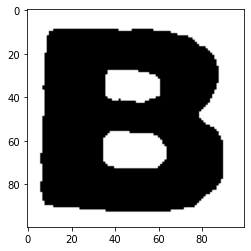

In [3]:
#
fixed_size = tuple((100, 100))
image = cv.imread('./English/Img/GoodImg/Bmp/Sample012/img012-00025.png')
# cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv.resize(image, fixed_size)
greyscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

print(greyscale[0,0], greyscale.mean())
if greyscale[0,0] >= greyscale.mean():
    
    greyscale[greyscale >= greyscale.mean()] = 0
    greyscale[greyscale < greyscale.mean()] = 1
else:
    
    greyscale[greyscale < greyscale.mean()] = 0
    greyscale[greyscale >= greyscale.mean()] = 1
    

    
plt.imshow(greyscale, cmap = 'Greys')
plt.show()


In [127]:
def getBinaryImage(image, fixed_size = tuple((100,100))):
    """Converts an image to a black/white binary image.
    Examines the corner to determine which cells to convert to 1 and which to 0.
    Aims to make the letters black - but doesn't always work!!"""
    
    new_image = cv.resize(image, fixed_size)
    greyscale = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)

    if greyscale[0,0] >= greyscale.mean():
        greyscale[greyscale < greyscale.mean()] = 1.0
        greyscale[greyscale >= greyscale.mean()] = 0.0
        
    else:
        greyscale[greyscale < greyscale.mean()] = 0.0
        greyscale[greyscale >= greyscale.mean()] = 1.0
        
    return greyscale.flatten()

In [286]:
# get the dataset
raw_dir = './English/Img/GoodImg/Bmp'
X = []
labels = [] # convert to y with encoding later
for _file in os.listdir(raw_dir):
    key = int(_file[-3:])
    curr_label = class_mapping[key]
    if key in range(11,37):
        for _sample in os.listdir(os.path.join(raw_dir,_file)):
            image = cv.imread(os.path.join(raw_dir, _file,_sample))
            bin_image = getBinaryImage(image)
            X.append(bin_image)
            labels.append(curr_label)

In [287]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataset
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# batch size
bs = 4

# encode labels
le = LabelEncoder()
le.fit(labels)
y = le.transform(labels)
# split test / train
X_train, X_test, y_train, y_test = map(
    torch.tensor, 
    train_test_split(
        X, 
        y,
        test_size=0.2, 
        random_state=0
        )
    )

# create Tensor datasets and dataloaders
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size= bs)
test_dl = DataLoader(test_ds, batch_size= bs) # not sure why *2??


In [236]:
## create a simple nn to start

class logReg(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10000, 36)

    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        return x

In [237]:
from torch import optim
net = logReg()
criterion = nn.CrossEntropyLoss() # for multi-class classification
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [238]:
# create training function to play with hyperparams
def Train(net, epochs, trainloader, criterion, optimizer):
    # train the network
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients (still not sure what this is really?)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # print stats
            running_loss += loss.item()
            if i % 100 == 99: # print every 2000 minibatches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0 # why reset this? - its an average loss for last 2000 mini batches


    print('Finished Training')


def Eval(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [239]:
Train(net, 2, train_dl, criterion, optimizer)

[1,   100] loss: 3.374
[1,   200] loss: 3.272
[1,   300] loss: 3.218
[1,   400] loss: 3.172
[1,   500] loss: 3.138
[1,   600] loss: 3.088
[1,   700] loss: 3.116
[1,   800] loss: 3.098
[1,   900] loss: 3.075
[1,  1000] loss: 3.102
[1,  1100] loss: 3.038
[1,  1200] loss: 3.041
[1,  1300] loss: 3.021
[1,  1400] loss: 3.038
[1,  1500] loss: 3.018
[2,   100] loss: 3.015
[2,   200] loss: 3.024
[2,   300] loss: 2.991
[2,   400] loss: 3.003
[2,   500] loss: 2.992
[2,   600] loss: 2.956
[2,   700] loss: 2.980
[2,   800] loss: 2.979
[2,   900] loss: 2.970
[2,  1000] loss: 2.994
[2,  1100] loss: 2.948
[2,  1200] loss: 2.966
[2,  1300] loss: 2.947
[2,  1400] loss: 2.971
[2,  1500] loss: 2.963
Finished Training


In [240]:
Eval(net, test_dl)

Accuracy of the network on the test images: 47 %


In [96]:
# those were pretty garbage. lets try adding some layers
class bigNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10000, 5000)
        self.linear2 = nn.Linear(5000, 1000)
        self.linear3 = nn.Linear(1000, 36)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return x

In [97]:
net = bigNet()

criterion = nn.CrossEntropyLoss() # for multi-class classification
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9) # decrease learning rate

Train(net, 2, train_dl, criterion, optimizer)


[1,   100] loss: 3.431
[1,   200] loss: 3.088
[1,   300] loss: 2.717
[1,   400] loss: 2.364
[1,   500] loss: 2.259
[1,   600] loss: 2.071
[1,   700] loss: 1.978
[2,   100] loss: 1.954
[2,   200] loss: 1.948
[2,   300] loss: 1.847
[2,   400] loss: 1.798
[2,   500] loss: 1.842
[2,   600] loss: 1.680
[2,   700] loss: 1.668
Finished Training


In [98]:
Eval(net, test_dl)

Accuracy of the network on the test images: 57 %


In [356]:
class convNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 20)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(1, 4, 10)
        # self.fc1 = nn.Linear(int(80 * 80 / 4), 800)
        self.fc1 = nn.Linear(int(4 * 15 * 15), 800)
        self.fc2 = nn.Linear(800, 200)
        self.fc3 = nn.Linear(200, 36)

    def forward(self, x):
        x = x.view(x.shape[0], 1, 100,100)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [537]:
net = convNet()

criterion = nn.CrossEntropyLoss() # for multi-class classification
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.05) # decrease learning rate

Train(net, 5, train_dl, criterion, optimizer)

[1,   100] loss: 3.563
[1,   200] loss: 3.150
[1,   300] loss: 2.599
[1,   400] loss: 2.187
[1,   500] loss: 1.827
[1,   600] loss: 1.681
[1,   700] loss: 1.568
[1,   800] loss: 1.431
[1,   900] loss: 1.252
[1,  1000] loss: 1.344
[2,   100] loss: 1.266
[2,   200] loss: 1.100
[2,   300] loss: 1.199
[2,   400] loss: 1.173
[2,   500] loss: 1.116
[2,   600] loss: 1.047
[2,   700] loss: 1.024
[2,   800] loss: 0.972
[2,   900] loss: 0.920
[2,  1000] loss: 1.030
[3,   100] loss: 1.005
[3,   200] loss: 0.851
[3,   300] loss: 0.987
[3,   400] loss: 0.952
[3,   500] loss: 0.904
[3,   600] loss: 0.946
[3,   700] loss: 0.913
[3,   800] loss: 0.894
[3,   900] loss: 0.799
[3,  1000] loss: 0.885
[4,   100] loss: 0.914
[4,   200] loss: 0.743
[4,   300] loss: 0.907
[4,   400] loss: 0.832
[4,   500] loss: 0.811
[4,   600] loss: 0.894
[4,   700] loss: 0.785
[4,   800] loss: 0.782
[4,   900] loss: 0.709
[4,  1000] loss: 0.819
[5,   100] loss: 0.851
[5,   200] loss: 0.674
[5,   300] loss: 0.799
[5,   400] 

In [538]:
Eval(net, test_dl)


Accuracy of the network on the test images: 72 %


In [534]:
# check against
correct_pred = {v: 0 for k,v in class_mapping.items() if k in range(11, 37)}
total_pred = {v: 0 for k,v in class_mapping.items() if k in range(11, 37)}


with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = net(images.float())
        _, predictions = torch.max(outputs, 1)
        # collect correct pred for each class
        for label, prediction in zip(labels, predictions):

            if label == prediction:
                correct_pred[le.inverse_transform([label])[0]] += 1
            total_pred[le.inverse_transform([label])[0]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: A     is 96.8 %
Accuracy for class: B     is 36.0 %
Accuracy for class: C     is 87.8 %
Accuracy for class: D     is 78.4 %
Accuracy for class: E     is 89.0 %
Accuracy for class: F     is 44.4 %
Accuracy for class: G     is 90.3 %
Accuracy for class: H     is 77.1 %
Accuracy for class: I     is 83.0 %
Accuracy for class: J     is 53.3 %
Accuracy for class: K     is 87.0 %
Accuracy for class: L     is 86.8 %
Accuracy for class: M     is 83.9 %
Accuracy for class: N     is 90.1 %
Accuracy for class: O     is 85.5 %
Accuracy for class: P     is 88.5 %
Accuracy for class: Q     is 11.1 %
Accuracy for class: R     is 81.4 %
Accuracy for class: S     is 89.8 %
Accuracy for class: T     is 84.6 %
Accuracy for class: U     is 52.0 %
Accuracy for class: V     is 93.8 %
Accuracy for class: W     is 70.0 %
Accuracy for class: X     is 69.2 %
Accuracy for class: Y     is 58.3 %
Accuracy for class: Z     is 80.0 %


In [465]:
# try tensorboard

from torch.utils.tensorboard import SummaryWriter
import torchvision

writer = SummaryWriter('runs/letter_recog_experiment1')

In [466]:
images.view(4, 100, 100)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [472]:
dataiter = iter(train_dl)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)#.mean(dim = 0, dtype = float)

def showImg(img):
    img = img.mean(dim = 0, dtype = float)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.reshape(400, 100), (1,0)), cmap = 'Greys')

# plt.imshow(images.view( 400, 100), cmap = 'Greys')
# img_grid.shape
writer.add_image('Letter outputs', img_grid)

In [475]:
writer.add_graph(net, images.float())
writer.close()

In [524]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

N = 10

# select random images and their target indices
images, labels = select_n_random(train_ds.tensors[0], train_ds.tensors[1], n = N)

# # get the class labels for each image
class_labels = [le.inverse_transform([lab])[0][0] for lab in labels]

# # log embeddings
features = images.view(-1, 100 * 100)
print(features.shape)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1).view(N, 1, 100, 100))
writer.close()

torch.Size([10, 10000])


In [520]:
images.unsqueeze(1).view(100, 1, 100, 100).shape

torch.Size([100, 1, 100, 100])

In [511]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)

100%|██████████| 26421880/26421880 [00:32<00:00, 819174.90it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 93343.24it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:05<00:00, 786791.63it/s] 


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [515]:

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# # get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# # log embeddings
features = images.view(-1, 28 * 28)
print(features.shape)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

torch.Size([100, 784])


In [517]:
images.unsqueeze(1).shape

torch.Size([100, 1, 28, 28])